In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
# connecting to gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = f"/content/gdrive/MyDrive/ds/"

Mounted at /content/gdrive


In [3]:
# reading dataset to pandas dataframe
data = pd.read_csv("/content/gdrive/MyDrive/ds/Pokemon.csv")
# show general dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      1072 non-null   int64 
 1   name        1072 non-null   object
 2   type1       1072 non-null   object
 3   type2       574 non-null    object
 4   total       1072 non-null   int64 
 5   hp          1072 non-null   int64 
 6   attack      1072 non-null   int64 
 7   defense     1072 non-null   int64 
 8   sp_attack   1072 non-null   int64 
 9   sp_defense  1072 non-null   int64 
 10  speed       1072 non-null   int64 
 11  generation  1072 non-null   int64 
 12  legendary   1072 non-null   bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 101.7+ KB


Attributes description provided by the dataset authors 

* Number: The ID for each pokemon

* Name: The name of each pokemon

* Type 1: Each pokemon has a type, this determines weakness/resistance to attacks

* Type 2: Some pokemon are dual type and have 2

* Total: Sum of all stats that come after this, a general guide to how strong a pokemon is

* HP: Hit points, or health, defines how much damage a pokemon can withstand before fainting

* Attack: The base modifier for normal attacks (eg. Scratch, Punch)

* Defense: The base damage resistance against normal attacks

* SP Atk: Special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)

* SP Def: Special defense, the base damage resistance against special attacks

* Speed: Determines which pokemon attacks first each round

* Generation: The generation of games where the pokemon was first introduced

* Legendary: Some pokemon are much rarer than others, and are dubbed "legendary"

Only 8 columns from 5th to 12th contain numerical data suitable for the current task of clustering. 

In [4]:
# counting total number of gaps per column
data.isnull().sum()

number          0
name            0
type1           0
type2         498
total           0
hp              0
attack          0
defense         0
sp_attack       0
sp_defense      0
speed           0
generation      0
legendary       0
dtype: int64

Only a single column which is not relevant for the analysis has gaps, thus existence of empty cells is ignored

In [5]:
# show description of the selected numerical data
data.iloc[:, 4:12].describe()

,total,hp,attack,defense,sp_attack,sp_defense,speed,generation
count,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000
mean,440.885261,70.486940,80.938433,74.968284,73.273321,72.476679,68.792910,4.294776
std,121.379077,26.868039,32.463582,31.208059,32.643119,27.934253,30.076281,2.346472
min,175.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000
25%,330.000000,50.000000,56.000000,52.000000,50.000000,50.000000,45.000000,2.000000
50%,460.500000,68.000000,80.000000,70.000000,65.000000,70.000000,65.000000,4.000000
75%,519.250000,84.000000,100.000000,90.000000,95.000000,90.000000,90.000000,6.000000
max,1125.000000,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000,8.000000


In [6]:
# show first 10 rows of the selected numerical data
data.iloc[:, 4:12].head(10)

,total,hp,attack,defense,sp_attack,sp_defense,speed,generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,525,80,82,83,100,100,80,1
5,309,39,52,43,60,50,65,1
6,405,58,64,58,80,65,80,1
7,534,78,84,78,109,85,100,1
8,634,78,130,111,130,85,100,1
9,634,78,104,78,159,115,100,1


Based on the overall dataset information listed above, the most suitable columns are attack, defense, and hp. 

Speed, special attack and defense don't describe the essential features of pokemons but rather very specific in-battle characteristics. While the total provides too generalized summary of strength.

Therefore, two models will be defined by the following combinations of variables:

* attack, defense, hp
* attack, defense

In [7]:
# setting common variables
inits = 10  # number of KMeans inits
seed = 1337  # random seed to reproduce the results

In [8]:
# forming NumPy array of the columns from 7th to 8th
X2 = data.iloc[:, 6:8].values
# forming NumPy array of the columns from 6th to 8th
X3 = data.iloc[:, 5:8].values

In [9]:
# creating a list of clusters with a number of centroids ranging from 1 to 20
top_means = 20
clusters_2d, clusters_3d = [], []
for k in range(1, top_means+1):
  # initializing reproducible KMeans algorithm with the 'k-means++' method
  # and fitting the input datasets of X features clustered into k groups
  kmeans_2d = KMeans(n_clusters=k, init='k-means++', 
                  random_state=seed, n_init=inits)
  kmeans_2d.fit(X2)
  # the same initialization for the extended dataset of 3 numerical features
  kmeans_3d = KMeans(n_clusters=k, init='k-means++', 
                  random_state=seed, n_init=inits)
  kmeans_3d.fit(X3)
  # collecting models inertia (sum of squared distances of samples to their 
  # closest cluster center) for the future analysis 
  clusters_2d.append(kmeans_2d.inertia_)
  clusters_3d.append(kmeans_3d.inertia_)

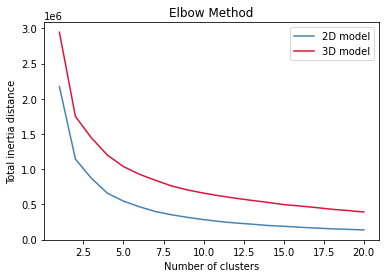

In [10]:
# plotting the collected cluster distances for the elbow method analysis 
# to find a balance between the model complexity and clustering accuracy
plt.plot(range(1, top_means+1), clusters_2d, label="2D model", color="steelblue")
plt.plot(range(1, top_means+1), clusters_3d, label="3D model", color="crimson")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Total inertia distance')
plt.legend()
plt.show()

The naming of the elbow analysis method is referencing a shape of the inertia curve that looks like an arm elbow. 

The curves are similar in shape, yet the additional "HP" feature, which extends the dimensionality of the model features space, demonstrates generally higher inertia distance and data sparseness than its simpler version, as expected.  

Based on the resulting graph, the optimal number of clusters would be defined as 7 for both 2D and 3D models.

In [11]:
# defining colors for all 7 clusters of the scatter plot
colors = ["gold", "tomato", "darkgreen", "royalblue", "crimson", "steelblue", "indigo"]
K = 7  # number of cluster centroids 

In [12]:
# the initial cluster centers are selected using 'k-means++' initialization method
# to segment the data into 7 distinct groups based on their feature similarity

model_2d = KMeans(n_clusters=K, init='k-means++', random_state=seed, n_init=inits)
Y2_kmeans = model_2d.fit_predict(X2)
print(f"Frequencies of the predicted numerical labels for the {X2.shape} feature space:") 
for num, count in dict(Counter(Y2_kmeans)).items():
    print(f"Cluster {num} : {count}")

model_3d = KMeans(n_clusters=K, init='k-means++', random_state=seed, n_init=inits)
Y3_kmeans = model_3d.fit_predict(X3) 
print(f"Frequencies of the predicted numerical labels for the {X3.shape} feature space:")
for num, count in dict(Counter(Y3_kmeans)).items():
    print(f"Cluster {num} : {count}")

Frequencies of the predicted numerical labels for the (1072, 2) feature space:
Cluster 1 : 230
Cluster 6 : 239
Cluster 3 : 180
Cluster 2 : 130
Cluster 5 : 85
Cluster 4 : 186
Cluster 0 : 22
Frequencies of the predicted numerical labels for the (1072, 3) feature space:
Cluster 5 : 222
Cluster 1 : 295
Cluster 2 : 156
Cluster 6 : 123
Cluster 3 : 83
Cluster 0 : 175
Cluster 4 : 18


In [13]:
# setting new dataframe columns containing the predicted cluster labels
col_2d, col_3d = "2D Cluster","3D Cluster"
data[col_2d], data[col_3d] = Y2_kmeans, Y3_kmeans

# calculating the cross-tabulation of 2D and 3D label sequences to shows 
# how many times each pair of labels occurred together
cross_tab = pd.crosstab(data[col_2d], data[col_3d], 
                       rownames=[col_2d], colnames=[col_3d])
print(f"Cross-tabulation of label pairs matches:\n{cross_tab}")

# showing the percentage of matching labels between the two KMeans models, 
# while accounting for the size of the dataset and the number of clusters
relative_cross_tab = cross_tab / cross_tab.values.sum() * K * cross_tab
print(f"Relative percentage of label pairs matches:\n{relative_cross_tab.round(2)}")

# calculate the percentage of matching labels between the two KMeans models to 
# quantify the degree of agreement between the predicted cluster labels 
matching_labels = relative_cross_tab.values.sum() / cross_tab.values.sum() * 100
print(f"Percentage of the matching cross-model labels: {matching_labels:.2f}%")

Cross-tabulation of label pairs matches:
3D Cluster    0    1   2   3  4    5   6
2D Cluster                              
0             0    0   0   7  0    0  15
1             0   19   1   0  4  206   0
2             2    0  47   7  1    0  73
3             0   67  71   0  1    7  34
4           154    7  19   1  4    0   1
5            17    0   0  68  0    0   0
6             2  202  18   0  8    9   0
Relative percentage of label pairs matches:
3D Cluster       0       1      2      3     4       5      6
2D Cluster                                                   
0             0.00    0.00   0.00   0.32  0.00    0.00   1.47
1             0.00    2.36   0.01   0.00  0.10  277.10   0.00
2             0.03    0.00  14.42   0.32  0.01    0.00  34.80
3             0.00   29.31  32.92   0.00  0.01    0.32   7.55
4           154.86    0.32   2.36   0.01  0.10    0.00   0.01
5             1.89    0.00   0.00  30.19  0.00    0.00   0.00
6             0.03  266.44   2.12   0.00  0.42    

The predicted cluster labels of both KMeans models fitted to similar data subsets and initialized in the same setting demonstrate a high percentage of the cross-model clusters matching.

Hence, the feature of pokemon's health points has influenced the clusterization only a little. Further analysis is made only for the model trained on "attack" and "defense" features due to limitations of 3D scatter plot interpretability. 

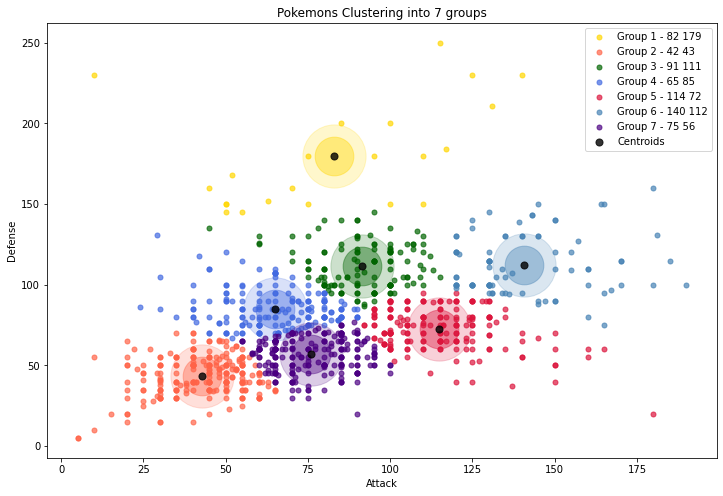

In [14]:
# creating two-dimensional canvas
fig, ax = plt.subplots(figsize=(12, 8))
# loop over the predicted labels and dataset points grouped into 7 clusters
for k in range(K):
  # defining cluster centroid coordinates
  k_atk, k_dfn = model_2d.cluster_centers_[k, 0], model_2d.cluster_centers_[k, 1]
  # plotting a group of data points marked by the corresponding cluster color  
  ax.scatter(X2[Y2_kmeans==k, 0], X2[Y2_kmeans==k, 1], s=25, 
             c=colors[k], alpha=0.7,
             label=f'Group {k+1} - {int(k_atk)} {int(k_dfn)}')
  # plotting cluster centroid of the fitted KMeans model
  ax.scatter(k_atk,k_dfn, s=1500, c=colors[k], alpha=0.4)
  ax.scatter(k_atk,k_dfn, s=4000, c=colors[k], alpha=0.2)

# plotting cluster centroids of the fitted KMeans model
ax.scatter(model_2d.cluster_centers_[0:, 0], 
           model_2d.cluster_centers_[0:, 1], 
           s=50, c='black', label='Centroids', alpha=0.8)

ax.set_title(f'Pokemons Clustering into {K} groups')
ax.set_xlabel('Attack')
ax.set_ylabel('Defense')
plt.legend()
plt.show()

Cluster analysis:
1. very endurable due to the high defense, but vary in attack capabilities
2. low-level creatures with poor attack and defense potentials
3. the golden middle of both features, well-balanced fighters  
4. can defend themselves well enough, but have mediocre attack power
5. very good in attacking, but lack durability
6. excellent attack and very good defense talents
7. good enough in attacking but lack a proper protection

The low-level pokemons of the 2nd group are usually available for players at the beginning of the game. Then depending on the fighting style, players can pick more durable ones from the 4th group or more striking ones from 7th group. As the game progress continues, players can collect pokemons of the 3rd group well-balanced in stamina and punch power. At the same time, players can find more deadly but less resistant creatures of the 5th group. The ultimate goal of leveling up is collecting high-level pokemons from the 6th group. In addition, there are very hard-to-harm pokemons of the 1st group that has outstanding protection.

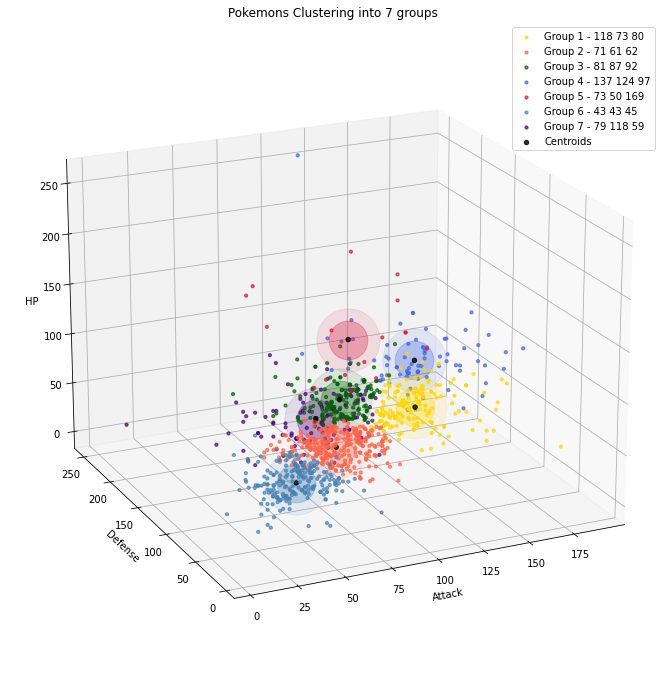

In [15]:
# creating three-dimensional canvas
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
# loop over the predicted labels and dataset points grouped into 7 clusters
for k in range(K):
  # defining cluster centroid coordinates
  k_atk, k_dfn = model_3d.cluster_centers_[k, 1], model_3d.cluster_centers_[k, 2]
  k_hp = model_3d.cluster_centers_[k, 0]
  # plotting a group of data points marked by the corresponding cluster color  
  ax.scatter(X3[Y3_kmeans == k, 1], X3[Y3_kmeans == k, 2], X3[Y3_kmeans == k, 0], 
             s=10, c=colors[k], alpha=0.7, 
             label=f'Group {k+1} - {int(k_atk)} {int(k_dfn)} {int(k_hp)}')
  # plotting cluster centroid of the fitted KMeans model
  ax.scatter(k_atk, k_dfn, k_hp, s=4000, c=colors[k], alpha=0.1)
  ax.scatter(k_atk, k_dfn, k_hp, s=1500, c=colors[k], alpha=0.3)

# plotting cluster centroids of the fitted KMeans model
ax.scatter(model_3d.cluster_centers_[:, 1], 
           model_3d.cluster_centers_[:, 2], 
           model_3d.cluster_centers_[:, 0], 
           s=20, c='black', label='Centroids', alpha=0.8)

ax.set_zlabel('HP')
ax.set_ylabel('Defense')
ax.set_xlabel('Attack')
ax.set_title(f'Pokemons Clustering into {K} groups')
ax.view_init(elev=20, azim=-115)
plt.legend()
plt.show()

3D scatter plot of pokemons clustering made only as an example of applying K-means algorithm on the data that has more than 2 features. 